# Unsupervised Sleep Stage Classification Pipeline
This notebook implements a deep learning pipeline for unsupervised classification of sleep stages in rat EEG signals using DMD and a transformer-based model.

In [81]:
# Import required libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mne
# Import DMD instead of EDMD
from pydmd import DMD
import matplotlib.patches as patches
from tqdm import tqdm  # Progress bar
from scipy.signal import butter, filtfilt
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.gridspec import GridSpec

## Data Loading and Preprocessing
- Load EDF file (channel 0)
- Normalize to [-1, 1]
- Remove outliers using sliding window (30s, 3x std)

In [57]:
def bandpass_filter(signal, sfreq, low=0.5, high=80, order=4):
    nyq = 0.5 * sfreq
    lowcut = low / nyq
    highcut = high / nyq
    b, a = butter(order, [lowcut, highcut], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

def load_and_preprocess_edf(filepath, window_sec=30, std_factor=3):
    raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
    signal = raw.get_data(picks=0)[0]  # channel 0
    sfreq = int(raw.info['sfreq'])
    # Bandpass filter 0.5-50Hz, both directions
    signal = bandpass_filter(signal, sfreq, low=0.5, high=49)
    # Normalize to [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    signal_norm = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    # Remove outliers in sliding windows
    win_samples = window_sec * sfreq
    cleaned = signal_norm.copy()
    for start in range(0, len(signal_norm), win_samples):
        end = min(start + win_samples, len(signal_norm))
        window = signal_norm[start:end]
        mean = np.mean(window)
        std = np.std(window)
        mask = np.abs(window - mean) < std_factor * std
        window_cleaned = np.where(mask, window, mean)
        cleaned[start:end] = window_cleaned
    return cleaned, sfreq

## Feature Extraction: Dynamic Mode Decomposition (DMD)
Extract features from sliding windows using DMD.

In [58]:
def extract_dmd_features(signal, sfreq, window_sec=30, step_sec=30, n_modes=10, save_path=None):
    win_samples = window_sec * sfreq
    step_samples = step_sec * sfreq
    features = []
    
    # Calculate number of windows for progress bar
    n_windows = (len(signal) - win_samples) // step_samples + 1
    
    # Use tqdm for progress tracking
    for start in tqdm(range(0, len(signal) - win_samples + 1, step_samples), 
                      desc="Extracting DMD features", 
                      total=n_windows):
        window = signal[start:start+win_samples]
        # DMD expects 2D array: (n_features, n_samples)
        X = window.reshape(1, -1)
        
        # Use DMD instead of EDMD
        dmd = DMD(svd_rank=n_modes)
        dmd.fit(X)
        
        # Use real part of first n_modes DMD amplitudes as features
        feat = np.real(dmd.amplitudes)[:n_modes]
        features.append(feat)
    
    features = np.array(features)
    
    # Save features if path is provided
    if save_path:
        # Save as numpy file
        np.save(f"{save_path}.npy", features)
        # Also save as CSV for compatibility with other software
        np.savetxt(f"{save_path}.csv", features, delimiter=',', header=','.join([f'mode_{i}' for i in range(n_modes)]))
        print(f"Features saved to {save_path}.npy and {save_path}.csv")
    
    return features

## Time Series Transformer (TST) Model
Define a simple transformer for unsupervised feature learning.

In [59]:
class SimpleTST(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        # Change output projection to map back to input_dim (instead of d_model)
        self.output_proj = nn.Linear(d_model, input_dim)  # This fixes the dimension mismatch
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (batch, seq_len, d_model)
        return self.output_proj(x)

### Train TST Model (Unsupervised)
Use reconstruction loss (autoencoder style) for unsupervised training.

In [60]:
def train_tst(features, device='cuda', epochs=20, batch_size=16, checkpoint_path='tst_checkpoint'):
    if not torch.cuda.is_available():
        raise RuntimeError('CUDA (GPU) is required for training. Please enable GPU runtime.')
    features = torch.tensor(features, dtype=torch.float32).to(device)
    dataset = TensorDataset(features)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = SimpleTST(input_dim=features.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        with tqdm(loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False) as t:
            for (batch,) in t:
                batch = batch.unsqueeze(1).to(device)
                out = model(batch)
                loss = criterion(out, batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * batch.size(0)
                t.set_postfix(loss=loss.item())
        avg_loss = epoch_loss / len(dataset)
        print(f'Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.6f}')
        torch.save(model.state_dict(), f'{checkpoint_path}_epoch{epoch+1}.pt')
    return model

## Clustering on Transformer Outputs
Apply KMeans to transformer-encoded features.

In [61]:
def get_tst_embeddings(model, features, device='cuda'):
    if not torch.cuda.is_available():
        raise RuntimeError('CUDA (GPU) is required for inference. Please enable GPU runtime.')
    model.eval()
    with torch.no_grad():
        feats = torch.tensor(features, dtype=torch.float32).unsqueeze(1).to(device)
        emb = model(feats).squeeze(1).cpu().numpy()
    return emb

def cluster_embeddings(embeddings, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

## Visualization
Plot EEG signal with rectangles for predicted clusters. This function is isolated for easy parameter modification.

In [62]:
def plot_eeg_with_clusters(signal, labels, sfreq, window_sec=30, start_sec=0, end_sec=30, colors=None):
    if colors is None:
        colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
    
    start_idx = int(start_sec * sfreq)
    end_idx = int(end_sec * sfreq)
    
    # Create figure with two subplots (EEG + hypnogram)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    
    # Plot 1: EEG Signal with cluster rectangles
    ax1.plot(np.arange(start_idx, end_idx)/sfreq, signal[start_idx:end_idx], color='black', lw=1)
    win_samples = window_sec * sfreq
    
    # Calculate signal range for rectangles
    signal_min = np.min(signal[start_idx:end_idx])
    signal_max = np.max(signal[start_idx:end_idx])
    
    # For each window that's in view
    for i, label in enumerate(labels):
        win_start = i * win_samples
        win_end = win_start + win_samples
        
        win_start_sec = win_start / sfreq
        win_end_sec = win_end / sfreq
        
        # Skip if window is outside view
        if win_end_sec <= start_sec or win_start_sec >= end_sec:
            continue
        
        # Draw rectangle on EEG plot
        rect_start = max(win_start_sec, start_sec)
        rect_end = min(win_end_sec, end_sec)
        rect = patches.Rectangle(
            (rect_start, signal_min),
            rect_end - rect_start,
            signal_max - signal_min,
            facecolor=colors[label % len(colors)],
            alpha=0.2,
            edgecolor=None
        )
        ax1.add_patch(rect)
        
        # Plot colored horizontal bar on hypnogram
        ax2.plot(
            [win_start_sec, win_end_sec],
            [label, label],
            color=colors[label % len(colors)],
            linewidth=10,
            solid_capstyle='butt'
        )
    
    # Configure EEG plot
    ax1.set_ylabel('EEG Amplitude')
    ax1.set_title('EEG Signal with Cluster Annotations')
    
    # Configure hypnogram
    unique_labels = sorted(set(labels))
    ax2.set_yticks(unique_labels)
    ax2.set_ylim(-0.5, max(unique_labels) + 0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Cluster')
    ax2.set_title('Cluster Hypnogram')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set common x limits
    plt.xlim(start_sec, end_sec)
    
    plt.tight_layout()
    plt.show()

## Pipeline Example
Run the pipeline on a sample EDF file.

In [63]:
# Force CUDA/GPU usage for the entire pipeline
device = 'cuda'
if not torch.cuda.is_available():
    raise RuntimeError('CUDA (GPU) is required for this pipeline. Please enable GPU runtime.')
print(f'CUDA available: {torch.cuda.is_available()}, Device count: {torch.cuda.device_count()}')
print(f'Using device: {torch.cuda.get_device_name(0)}')

edf_path = 'raw data/SC4001E0-PSG.edf'
signal, sfreq = load_and_preprocess_edf(edf_path)


CUDA available: True, Device count: 1
Using device: NVIDIA GeForce GTX 1080 Ti


/tmp/ipykernel_6154/656959244.py:10: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
/tmp/ipykernel_6154/656959244.py:10: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
/tmp/ipykernel_6154/656959244.py:10: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)


In [64]:
# Extract features and save them locally with timestamp for easy identification
import time
import os

# Create directory if it doesn't exist
os.makedirs('features', exist_ok=True)
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_path = f"features/dmd_features_{timestamp}"

# Use DMD instead of EDMD
features = extract_dmd_features(signal, sfreq, window_sec=10, step_sec=10, n_modes=10, save_path=save_path)
print(f"Extracted {features.shape[0]} windows with {features.shape[1]} features each")

Extracting DMD features: 100%|██████████| 7950/7950 [00:02<00:00, 3435.04it/s]

Features saved to features/dmd_features_20250502-122146.npy and features/dmd_features_20250502-122146.csv
Extracted 7950 windows with 1 features each


In [65]:
def load_dmd_features(filepath, format='npy'):
    """
    Load saved DMD features from disk.
    
    Parameters:
    -----------
    filepath : str
        Path to the saved features, without extension
    format : str, optional
        File format to load, either 'npy' or 'csv'. Default is 'npy'.
    
    Returns:
    --------
    features : numpy.ndarray
        The loaded features
    """
    import numpy as np
    import os
    
    if format.lower() == 'npy':
        file_path = f"{filepath}.npy"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        return np.load(file_path)
    elif format.lower() == 'csv':
        file_path = f"{filepath}.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        return np.loadtxt(file_path, delimiter=',', skiprows=1)
    else:
        raise ValueError("Format must be either 'npy' or 'csv'")

In [66]:
# Example: Load previously saved features
# You can replace this with the actual path to your saved features
# For example, using the timestamp from earlier: save_path variable
try:
    # Load the features we just saved
    loaded_features = load_dmd_features(save_path)
    print(f"Successfully loaded features from NPY: shape {loaded_features.shape}")
    
    # Compare with original features to verify they're the same
    print(f"Original and loaded features are identical: {np.allclose(features, loaded_features)}")
    
    # Alternatively, load from CSV
    # loaded_features_csv = load_dmd_features(save_path, format='csv')
    # print(f"Successfully loaded features from CSV: shape {loaded_features_csv.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please provide a valid path to saved features.")

Successfully loaded features from NPY: shape (7950, 1)
Original and loaded features are identical: True


In [67]:

# Train with checkpointing and progress bars (fixed parameter name)
tst_model = train_tst(features, device=device, epochs=5, checkpoint_path='tst_checkpoint')


/home/yahia/notebooks/.conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/5:   0%|          | 0/497 [00:00<?, ?it/s, loss=1.48]  

Epoch 1/5 - Avg Loss: 0.008754


Epoch 2/5 - Avg Loss: 0.000646


Epoch 3/5 - Avg Loss: 0.000428


Epoch 4/5 - Avg Loss: 0.000358


Epoch 5/5 - Avg Loss: 0.000408


In [68]:

embeddings = get_tst_embeddings(tst_model, features, device=device)
labels = cluster_embeddings(embeddings, n_clusters=4)


In [71]:
# Calculate length of signal in seconds based on sampling frequency
lensss = len(signal) / sfreq

print(f"Length of signal: {lensss:.2f} seconds ({lensss/60:.2f} minutes)")

Length of signal: 79500.00 seconds (1325.00 minutes)


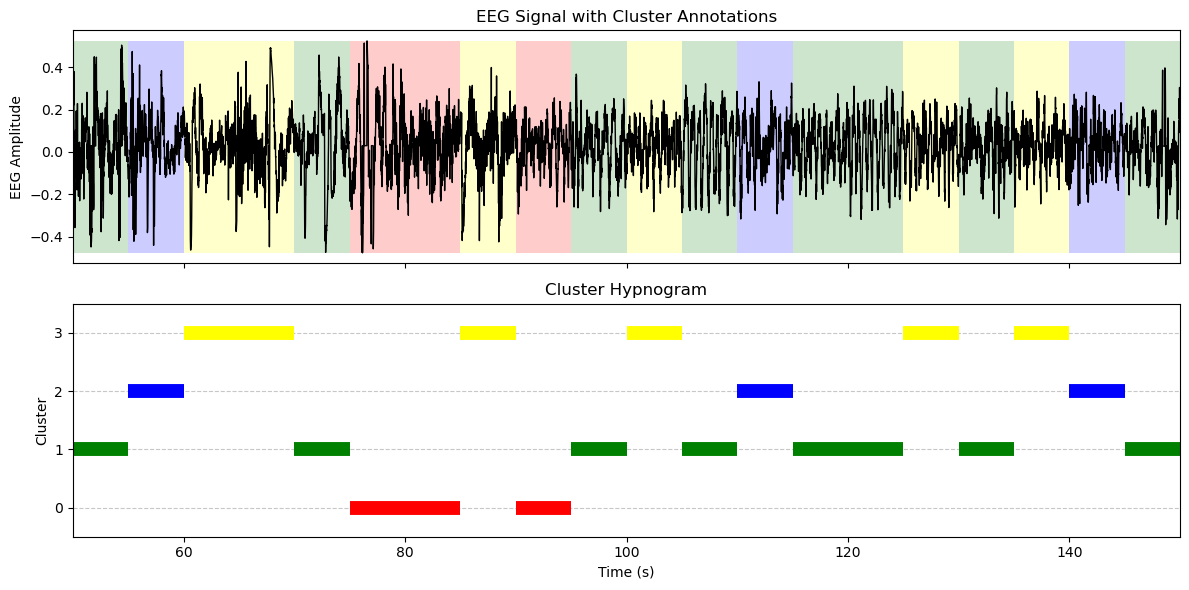

In [88]:
# Visualize for first 30 seconds
plot_eeg_with_clusters(signal, labels, sfreq, window_sec=5, start_sec=50, end_sec=150)

In [70]:
# Analyze clusters
num_clusters = len(np.unique(labels))
print(f"Number of clusters: {num_clusters}")

# Get basic statistics for each cluster
for cluster in range(num_clusters):
    cluster_mask = labels == cluster
    cluster_embeddings = embeddings[cluster_mask]
    cluster_size = len(cluster_embeddings)
    
    print(f"\nCluster {cluster}:")
    print(f"Size: {cluster_size} ({cluster_size/len(labels)*100:.2f}% of total)")
    
    # Get temporal distribution
    temporal_positions = np.where(cluster_mask)[0]
    print(f"Temporal distribution:")
    print(f"  First occurrence: {temporal_positions[0]} windows")
    print(f"  Last occurrence: {temporal_positions[-1]} windows")
    print(f"  Mean position: {np.mean(temporal_positions):.2f} windows")
    
    # Get basic statistics of embeddings in this cluster
    print(f"Embedding statistics:")
    print(f"  Mean: {np.mean(cluster_embeddings):.8f}")
    print(f"  Std: {np.std(cluster_embeddings):.8f}")
    print(f"  Min: {np.min(cluster_embeddings):.8f}")
    print(f"  Max: {np.max(cluster_embeddings):.8f}")

Number of clusters: 4

Cluster 0:
Size: 457 (5.75% of total)
Temporal distribution:
  First occurrence: 5 windows
  Last occurrence: 7938 windows
  Mean position: 3890.24 windows
Embedding statistics:
  Mean: -0.41648835
  Std: 0.07918858
  Min: -0.69646436
  Max: -0.31972596

Cluster 1:
Size: 3849 (48.42% of total)
Temporal distribution:
  First occurrence: 0 windows
  Last occurrence: 7946 windows
  Mean position: 4001.85 windows
Embedding statistics:
  Mean: -0.02106635
  Std: 0.02120919
  Min: -0.06442080
  Max: 0.01089823

Cluster 2:
Size: 1240 (15.60% of total)
Temporal distribution:
  First occurrence: 6 windows
  Last occurrence: 7949 windows
  Mean position: 3892.09 windows
Embedding statistics:
  Mean: -0.22295621
  Std: 0.04178028
  Min: -0.31867835
  Max: -0.16518381

Cluster 3:
Size: 2404 (30.24% of total)
Temporal distribution:
  First occurrence: 1 windows
  Last occurrence: 7944 windows
  Mean position: 3989.24 windows
Embedding statistics:
  Mean: -0.10840961
  Std: 0.